# Define and Train a Generative Model (e.g., a VAE)

### Preprocess Your Data

In [6]:
import numpy as np
import pandas as pd

# Load your dataset
data_path = "data2_stable.csv"
data = pd.read_csv(data_path)

# Extract the relevant numerical features from your dataset
numerical_features = ["volume", "ntypes", "natoms", "band_gap", "delta_e"]
compound_data = data[numerical_features].values

# Normalize the data if needed
compound_data = (compound_data.astype(np.float32) - 0.5) * 2
compound_data

array([[ 1.7235240e+02,  3.0000000e+00,  1.1000000e+01,  1.0699999e+00,
        -1.3218969e+00],
       [ 2.5425600e+02,  5.0000000e+00,  1.3000000e+01, -1.0000000e+00,
        -1.5500121e+00],
       [ 2.0656599e+02,  3.0000000e+00,  1.1000000e+01, -1.0000000e+00,
        -2.2345406e-01],
       ...,
       [ 9.6399002e+01,  5.0000000e+00,  7.0000000e+00, -1.0000000e+00,
        -1.6728911e+00],
       [ 9.4071404e+01,  5.0000000e+00,  7.0000000e+00, -1.0000000e+00,
        -1.6881639e+00],
       [ 6.2018600e+01,  3.0000000e+00,  5.0000000e+00, -1.0000000e+00,
         1.9217117e+00]], dtype=float32)

### Define the Generator

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation

z_dim = 100 # Dimension of random noise vector for the Generator

def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(Activation('relu'))
    model.add(Dense(compound_data.shape[1]))
    model.add(Activation('tanh'))
    return model

generator = build_generator()


###  Define the Discriminator

In [8]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(128, input_dim=compound_data.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

discriminator = build_discriminator()


 ### Build the GAN

In [9]:
from keras.models import Model
from keras.layers import Input

def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(z_dim,))
    compound = generator(z)
    valid = discriminator(compound)
    gan = Model(z, valid)
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return gan

gan = build_gan(generator, discriminator)


### Train the GAN

In [11]:
from keras.layers import Input
import numpy as np

def train_gan(generator, discriminator, gan, compound_data, epochs=5000, batch_size=64):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train the Discriminator
        idx = np.random.randint(0, compound_data.shape[0], batch_size)
        real_compounds = compound_data[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_compounds = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_compounds, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_compounds, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_labels)
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]} | G Loss: {g_loss}")


In [12]:
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, compound_data, epochs=5000)


Epoch 0 | D Loss: 0.5743900686502457 | G Loss: [0.669252872467041, 0.765625]
Epoch 1000 | D Loss: nan | G Loss: [nan, 0.0]
Epoch 2000 | D Loss: nan | G Loss: [nan, 0.0]
Epoch 3000 | D Loss: nan | G Loss: [nan, 0.0]
Epoch 4000 | D Loss: nan | G Loss: [nan, 0.0]


## Tuning the GAN Model

In [14]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv(data_path)
# Select the numerical features you want to use
numerical_features = ["volume", "ntypes", "natoms", "band_gap", "delta_e"] # Add other numerical features as needed
compound_data = df[numerical_features].values

# Scale the data to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
compound_data_scaled = scaler.fit_transform(compound_data)


In [15]:
def build_generator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(np.prod(input_shape), activation="tanh"))
    model.add(Reshape(input_shape))
    return model


In [16]:
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model


In [17]:
def train_gan(generator, discriminator, gan, compound_data, epochs=5000, batch_size=16):
    half_batch = batch_size // 2
    real_labels = np.ones((half_batch, 1)) * 0.9  # Label Smoothing
    fake_labels = np.zeros((half_batch, 1))
    
    for epoch in range(epochs):
        # Select a random half batch of real samples
        idx = np.random.randint(0, compound_data.shape[0], half_batch)
        real_samples = compound_data[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, generator.input_shape[1]))
        fake_samples = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, generator.input_shape[1]))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        print(f"Epoch {epoch} | D Loss: {d_loss[0]} | G Loss: {g_loss}")

    return generator, discriminator


In [20]:
def build_generator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(np.prod(input_shape), activation="tanh"))  # experiment with different activation here
    model.add(Reshape(input_shape))
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation="relu"))  # experiment with different activation here
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model


In [26]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=z_dim, activation='relu'))
    model.add(Dense(5, activation='linear'))  # 5 is the number of features in your data
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Hyperparameters
z_dim = 100
input_shape = 5  # number of features in your data

# Build and compile the Discriminator
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Build and compile the GAN
discriminator.trainable = False
z = Input(shape=(z_dim,))
compound = generator(z)
valid = discriminator(compound)
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Train the GAN (implement a training loop as per your requirement)


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def generate_samples(generator, n_samples, z_dim):
    # Generate random noise
    noise = np.random.normal(0, 1, (n_samples, z_dim))
    
    # Generate samples using the trained generator
    generated_samples = generator.predict(noise)
    
    return generated_samples

# Use the trained generator to generate samples
n_samples = 10
generated_samples = generate_samples(generator, n_samples, z_dim)

# Print or visualize the generated samples
print(generated_samples)

# If the data is 2D, you can visualize it using a scatter plot
if generated_samples.shape[1] == 2:
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Generated Samples')
    plt.show()


[[-1.2718502  -0.9336247  -0.61228    -0.8636417  -0.490932  ]
 [-1.5874363  -0.62406135  0.03032039 -1.1852616  -1.2790548 ]
 [-1.811811    0.6417014  -2.2134268   0.39779127 -0.600445  ]
 [-1.4811302   0.04004893  1.6174982   1.7796506  -0.58963895]
 [-0.9531221  -0.20877463  0.37979114  0.2853927  -1.936805  ]
 [-1.1555307  -0.47996986 -1.5667648  -0.6054698  -0.38450655]
 [-2.5642915   0.5769008   1.5334731   0.16410509 -0.43720686]
 [ 0.49493498  0.5434787   0.23585099  0.5401874  -0.29292843]
 [-1.3942543  -0.8473346  -0.6811099  -0.1645119  -0.91560036]
 [ 0.09249151 -1.338197    0.03043531  0.44405726 -0.9828422 ]]


## new GAN Model

In [30]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import initializers
from sklearn.preprocessing import StandardScaler

# Read CSV data
csv_file_path = "data2_stable.csv"
data = pd.read_csv(csv_file_path)


In [31]:
# Select and preprocess relevant attributes
features = ['volume', 'ntypes', 'natoms', 'band_gap', 'delta_e', 'stability']
X = data[features]

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [64]:
X

array([[ 1.72520000e+04,  2.13130000e+04,  1.03785000e+05, ...,
         1.03500000e+00, -1.60948450e-01,  7.24652464e-02],
       [ 2.72230000e+04,  2.19090000e+04,  6.00559000e+05, ...,
         0.00000000e+00, -2.75006081e-01,  0.00000000e+00],
       [ 1.79010000e+04,  2.21910000e+04,  1.05559000e+05, ...,
         0.00000000e+00,  3.88272970e-01,  4.05408951e-01],
       ...,
       [ 1.45330000e+04,  9.44000000e+03,  8.04850000e+04, ...,
         0.00000000e+00, -3.36445565e-01,  0.00000000e+00],
       [ 1.45350000e+04,  9.45200000e+03,  8.04870000e+04, ...,
         0.00000000e+00, -3.44081951e-01,  0.00000000e+00],
       [ 2.23400000e+04,  1.00310000e+04,  1.81490000e+05, ...,
         0.00000000e+00,  1.46085581e+00,  1.46085581e+00]])

In [32]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim, activation='relu'))
    model.add(Dense(len(features), activation='linear'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Dense(128, input_dim=len(features), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [33]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(z_dim,))
    compound = generator(z)
    validity = discriminator(compound)
    gan = Model(z, validity)
    return gan

z_dim = 100
optimizer = Adam(0.0002, 0.5)

# Build and compile Discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build and compile Generator
generator = build_generator(z_dim)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


In [49]:
from keras.layers import Input, Dense, Dropout, Reshape, Flatten, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your data here
import pandas as pd

def load_data():
    # Define the CSV file location
    file_path = 'data2_stable.csv'

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Extract the features and target variable
    # In this example, I'm assuming that the target variable (e.g., whether it's a stealth material or not) is present in the DataFrame.
    # You might need to adjust this to fit your specific data and problem.
    X = df[['entry_id', 'calculation_id', 'icsd_id', 'formationenergy_id', 'duplicate_entry_id',
            'volume', 'ntypes', 'natoms', 'band_gap', 'delta_e', 'stability']].values
    y = df['stability_label'].map({'stable': 1, 'unstable': 0}).values

    return X, y

# Check and handle NaN values in your dataset
def clean_data(X):
    if np.isnan(X).any():
        X = np.nan_to_num(X) # You might want to handle NaN values differently depending on your data
    return X

# Normalize the features
def normalize_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# Define the GAN
class GAN():
    def __init__(self):
        self.img_shape = (X_train.shape[1],)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        # self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(Dropout(0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Dropout(0.5))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, sample_interval=1000):
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, real)

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

# Load the data
X, y = load_data()
X_cleaned = clean_data(X)
X_scaled, scaler = normalize_features(X_cleaned)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Train the GAN
gan = GAN()
gan.train(X_train, epochs=2000)


0 [D loss: 0.720264, acc.: 47.66%] [G loss: 0.773796]
1 [D loss: 0.705937, acc.: 54.30%] [G loss: 0.753652]
2 [D loss: 0.708255, acc.: 51.95%] [G loss: 0.736428]
3 [D loss: 0.710846, acc.: 47.66%] [G loss: 0.720402]
4 [D loss: 0.704452, acc.: 47.27%] [G loss: 0.701104]
5 [D loss: 0.697984, acc.: 50.39%] [G loss: 0.690221]
6 [D loss: 0.687812, acc.: 55.08%] [G loss: 0.686018]
7 [D loss: 0.696162, acc.: 45.70%] [G loss: 0.675747]
8 [D loss: 0.682976, acc.: 51.95%] [G loss: 0.658073]
9 [D loss: 0.683491, acc.: 48.83%] [G loss: 0.661438]
10 [D loss: 0.684992, acc.: 49.61%] [G loss: 0.668833]
11 [D loss: 0.686444, acc.: 41.80%] [G loss: 0.648528]
12 [D loss: 0.677133, acc.: 48.83%] [G loss: 0.642457]
13 [D loss: 0.682180, acc.: 47.66%] [G loss: 0.638330]
14 [D loss: 0.675353, acc.: 50.78%] [G loss: 0.636535]
15 [D loss: 0.671973, acc.: 55.08%] [G loss: 0.638809]
16 [D loss: 0.672754, acc.: 56.25%] [G loss: 0.639614]
17 [D loss: 0.671768, acc.: 54.69%] [G loss: 0.640629]
18 [D loss: 0.672272

In [63]:
X_scaled

array([[-0.27013737, -0.27915173, -0.29920896, ...,  0.72951545,
         0.48308984, -0.09484461],
       [-0.13635731, -0.26754599,  2.14319774, ..., -0.34754292,
         0.32657534, -0.38176303],
       [-0.26142979, -0.26205468, -0.29048703, ..., -0.34754292,
         1.23675371,  1.22341051],
       ...,
       [-0.30661796, -0.51035142, -0.41376423, ..., -0.34754292,
         0.2422656 , -0.38176303],
       [-0.30659113, -0.51011775, -0.41375439, ..., -0.34754292,
         0.23178664, -0.38176303],
       [-0.2018721 , -0.49884304,  0.08283038, ..., -0.34754292,
         2.70859531,  5.40233992]])

In [62]:
X_train

array([[-0.39559894, -0.53956052, -0.59857186, ..., -0.34754292,
         0.43324358, -0.18637135],
       [-0.28076356, -0.29903339, -0.33886082, ...,  2.01157913,
        -1.87641478, -0.38176303],
       [-0.24790554, -0.50920253, -0.2747492 , ..., -0.34754292,
        -0.82340727, -0.36070964],
       ...,
       [-0.21518168, -0.52238557,  0.01732739, ..., -0.34754292,
         1.43368741,  2.17761053],
       [-0.36072838, -0.48375168, -0.52443051, ..., -0.34754292,
         0.14122655, -0.38176303],
       [-0.21456451, -0.51190924,  0.01853685, ...,  0.03228926,
         1.50741132,  3.04923941]])

## Saving th Model

In [50]:
from keras.models import load_model

# Assume the GAN object is 'gan' and the generator is an attribute of this object
gan.generator.save('generator_model.h5')


In [61]:
# Load the generator model
loaded_generator = load_model('generator_model.h5')

# Generate a new compound (e.g., using a random noise vector)
noise = np.random.normal(0, 1, (1, 100))
generated_compound = loaded_generator.predict(noise)
print(generated_compound)
# Assuming 'generated_compound' is your generated compound with shape (batch_size, 11)
# and your classification model expects an input shape of (batch_size, 2)

# Reshape or select the necessary part of the generated compound
reshaped_compound = generated_compound[:, :2]  # Selecting the first two features, for example

# Predict the suitability for stealth
prediction = classification_model.predict(reshaped_compound)

# Interpret the prediction as needed, e.g., as a binary classification

# Reshape or process the generated_compound as required for the next model
prediction

[[-0.00843466  0.78998077  0.9996406   0.89096045 -0.10352775  0.8897728
   0.99999917  0.6205351   0.2830931  -0.9441481   0.674871  ]]


array([[0.3264027]], dtype=float32)

## Making GAN Model which considers NAme Feature

In [65]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_and_preprocess_data():
    # Read the data
    file_path = 'data2_stable.csv'
    df = pd.read_csv(file_path)

    # Select the features
    features = ['volume', 'ntypes', 'natoms', 'band_gap', 'delta_e']
    X = df[features]

    # Stability label encoding
    df['stability_label'] = df['stability_label'].map({'stable': 1, 'unstable': 0})

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df['stability_label']


In [73]:
len(df)

5

### As names are categorical we are converting into it's embeddings

In [75]:
file_path = 'data2_stable.csv'
df = pd.read_csv(file_path)

# Select the features
features = ['volume', 'ntypes', 'natoms', 'band_gap', 'delta_e']
X = df[features]

# Stability label encoding
df['stability_label'] = df['stability_label'].map({'stable': 1, 'unstable': 0})

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
df.head(10)

name  entry_id  calculation_id   icsd_id  formationenergy_id  \
0    Ga2Os     17252           21313  103785.0             4077096   
1   UGa5Os     27223           21909  600559.0             4077456   
2    PuOs2     17901           22191  105559.0             4077750   
3    CeOs2     29146           22197  621730.0             4077759   
4    Cr3Os     29569           27756  626494.0             4078962   
5     SiOs      3181           28159   15692.0             4079124   
6    Mo3Os     17710           30166  105054.0             4079574   
7    Nb3Os     17739           31046  105184.0             4079760   
8      OsC     21369           31694  168277.0             4080030   
9  Sc3OsC4     26820           33803  420076.0             4081293   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0               17252     Ga2 Os1                 AB2     TiSi2       Fddd   
1               27223  Ga5 Os1 U1                ABC5   CoHoGa5     P4/mmm   
2               17901     Os2 Pu1                 AB2     Cu2Mg      Fd-3m   
3               29146     Ce1 Os2                 AB2     Cu2Mg      Fd-3m   
4               29569     Cr3 Os1                 AB3     Cr3Si      Pm-3n   
5                3181     Os1 Si1                  AB      FeSi       P213   
6               17710     Mo3 Os1                 AB3     Cr3Si      Pm-3n   
7               17739     Nb3 Os1                 AB3     Cr3Si      Pm-3n   
8               21369      C1 Os1                  AB        CO       P213   
9               26820  C4 Os1 Sc3               AB3C4   Sc3FeC4       Immm   

   ...  ntypes  natoms                                          unit_cell  \
0  ...       2       6  [[0.0, -4.764636, 0.0], [4.156028, -2.382318, ...   
1  ...       3       7  [[4.362245, 0.0, 0.0], [0.0, 4.362245, 0.0], [...   
2  ...       2       6  [[3.729918, -3.729918, 0.0], [-3.729918, 0.0, ...   
3  ...       2       6  [[3.875985, -3.875985, 0.0], [-3.875985, 0.0, ...   
4  ...       2       8  [[4.626572, 0.0, 0.0], [0.0, 4.626572, 0.0], [...   
5  ...       2       8  [[4.786845, 0.0, 0.0], [0.0, 4.786845, 0.0], [...   
6  ...       2       8  [[4.993792, 0.0, 0.0], [0.0, 4.993792, 0.0], [...   
7  ...       2       8  [[5.170717, 0.0, 0.0], [0.0, 5.170717, 0.0], [...   
8  ...       2       8  [[4.456843, 0.0, 0.0], [0.0, 4.456843, 0.0], [...   
9  ...       3       8  [[-3.346736, 0.0, 0.0], [0.0, -4.483525, 0.0],...   

                                               sites band_gap   delta_e  \
0  ['Ga @ 0.332 0.336 0', 'Ga @ 0.668 0.664 0', '...    1.035 -0.160948   
1  ['Ga @ 0.5 0.5 0', 'Ga @ 0.5 0 0.301', 'Ga @ 0...    0.000 -0.275006   
2  ['Os @ 0.375 0.75 0.125', 'Os @ 0.375 0.25 0.6...    0.000  0.388273   
3  ['Ce @ 0 0 0', 'Ce @ 0.75 0.5 0.25', 'Os @ 0.3...    0.000  0.031155   
4  ['Cr @ 0.5 0.25 0', 'Cr @ 0.5 0.75 0', 'Cr @ 0...    0.000  0.014774   
5  ['Os @ 0.123 0.123 0.123', 'Os @ 0.877 0.623 0...    0.620 -0.363600   
6  ['Mo @ 0.5 0.25 0', 'Mo @ 0.5 0.75 0', 'Mo @ 0...    0.000  0.014309   
7  ['Nb @ 0.5 0.25 0', 'Nb @ 0.5 0.75 0', 'Nb @ 0...    0.000 -0.250872   
8  ['C @ 0.058 0.058 0.058', 'C @ 0.942 0.558 0.4...    0.434  0.771814   
9  ['C @ 0.628 0.467 0.256', 'C @ 0.628 0.789 0.2...    0.000 -0.439366   

   stability       fit calculation_label stability_label  
0   0.072465  standard            static               1  
1   0.000000  standard            static               0  
2   0.405409  standard            static               1  
3   0.049844  standard            static               0  
4   0.025922  standard            static               0  
5   0.012857  standard            static               0  
6   0.031122  standard            static               0  
7   0.000000  standard            static               0  
8   0.771814  standard            static               1  
9   0.002392  standard            static               0  

[10 rows x 21 columns]

In [83]:
from collections import Counter
import re
import pandas as pd

# Regular expression to match elements and their counts
pattern = re.compile(r'([A-Z][a-z]*)(\d*)')

def name_to_composition(name):
    # Find all elements and counts in the name
    elements_counts = pattern.findall(name)
    
    # Create a counter for the elements
    composition = Counter()
    for element, count in elements_counts:
        count = int(count) if count else 1
        composition[element] += count

    return composition

# Create a DataFrame with the compositions
composition_df = pd.DataFrame.from_records(
    df['name'].apply(name_to_composition).tolist()
).fillna(0)

# Include the composition DataFrame in your features
X = pd.concat([df[['volume', 'ntypes', 'natoms', 'band_gap', 'delta_e']], composition_df], axis=1).values


In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
composition_df

Ga   Os    U   Pu   Ce   Cr   Si   Mo   Nb    C  ...   Ta   Cs   Hg  \
0     2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     5.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1545  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0  0.0   
1546  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0  0.0   
1547  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0  0.0   
1548  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0  0.0   
1549  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0  0.0   

       Tl   Ac   Re   Pa   Pm   Tc   Co  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
1545  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1546  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1547  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1548  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1549  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1550 rows x 84 columns]

### Build the GAN

In [85]:
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model

def build_generator(input_dim, output_dim):
    input_noise = Input(shape=(input_dim,))
    x = Dense(128)(input_noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(output_dim, activation='tanh')(x) # Scaled to match the normalized data
    model = Model(input_noise, x)
    return model

# Example of creating the generator
input_dim = 100
output_dim = X_scaled.shape[1] # Assuming X_scaled is the transformed data
generator = build_generator(input_dim, output_dim)


In [87]:
from tensorflow.keras.optimizers import Adam

def build_discriminator(input_dim):
    input_data = Input(shape=(input_dim,))
    x = Dense(256)(input_data)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_data, x)
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example of creating the discriminator
discriminator = build_discriminator(output_dim)


In [88]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(input_dim,))
    compound = generator(z)
    validity = discriminator(compound)
    model = Model(z, validity)
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    return model

# Example of creating the full GAN
gan = build_gan(generator, discriminator)


In [92]:
import numpy as np

def train_gan(generator, discriminator, gan, X_real, epochs=10000, batch_size=128, input_dim=100):
    # Labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real data
        idx = np.random.randint(0, X_real.shape[0], batch_size)
        real_data = X_real[idx]

        # Generate a batch of new data
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        fake_data = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (using the combined GAN model, with the discriminator weights frozen)
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        # Print progress and optionally save models, generate plots, etc.
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Discriminator Loss: {d_loss[0]} | Generator Loss: {g_loss}")
            
    return generator


In [123]:
from keras.layers import Dropout

def build_generator(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(X_real.shape[1], activation='tanh'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_gan(generator, discriminator, gan, X_real, epochs=10000, batch_size=128):
    history = {'d_loss': [], 'g_loss':[], 'd_acc': []}  # To keep track of the loss during training

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_real.shape[0], batch_size)
        real_data = X_real[idx]
        fake_data = generator.predict(np.random.normal(0, 1, (batch_size, input_dim)))
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train GAN (Generator)
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Save losses and accuracy
        history['d_loss'].append(d_loss[0])
        history['g_loss'].append(g_loss)
        history['d_acc'].append(100*d_loss_real[1])

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    return generator, history

input_dim = 100  
generator = build_generator(input_dim)
discriminator = build_discriminator(X_real.shape[1])
gan = build_gan(generator, discriminator)

adam_optimizer = Adam(lr=0.0002, clipvalue=1.0)

# Compile models
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Training GAN
generator, history = train_gan(generator, discriminator, gan, X_real)


0 [D loss: 0.731388, acc.: 44.14%] [G loss: 0.709889]
1 [D loss: 0.741084, acc.: 36.72%] [G loss: 0.673499]
2 [D loss: 0.751765, acc.: 25.78%] [G loss: 0.637362]
3 [D loss: 0.773336, acc.: 24.61%] [G loss: 0.606865]
4 [D loss: 0.798513, acc.: 20.70%] [G loss: 0.573514]
5 [D loss: 0.813038, acc.: 19.14%] [G loss: 0.539473]
6 [D loss: 0.821276, acc.: 23.83%] [G loss: 0.515509]
7 [D loss: 0.865861, acc.: 17.58%] [G loss: 0.490677]
8 [D loss: 0.883331, acc.: 20.70%] [G loss: 0.442686]
9 [D loss: 0.906221, acc.: 21.09%] [G loss: 0.435069]
10 [D loss: 0.933421, acc.: 17.97%] [G loss: 0.428737]
11 [D loss: 0.960078, acc.: 16.02%] [G loss: 0.401918]
12 [D loss: 0.978732, acc.: 15.62%] [G loss: 0.394788]
13 [D loss: 0.980765, acc.: 20.31%] [G loss: 0.370548]
14 [D loss: 0.982114, acc.: 19.14%] [G loss: 0.361439]
15 [D loss: 1.023673, acc.: 19.92%] [G loss: 0.341729]
16 [D loss: 1.005658, acc.: 20.70%] [G loss: 0.323290]
17 [D loss: 1.029132, acc.: 22.66%] [G loss: 0.328834]
18 [D loss: 1.055322

KeyboardInterrupt: 

In [122]:
X_real[0]

array([-0.16872334, -0.87946312,  0.10297022,  0.72908422,  0.48308984,
        5.08352152,  2.99143536, -0.216464  , -0.17013628, -0.14338715,
       -0.09648802, -0.26647067, -0.09121361, -0.08359372, -0.3741207 ,
       -0.10247702, -0.17973495, -0.12275176, -0.2256234 , -0.13892264,
       -0.11500111, -0.13554588, -0.10926148, -0.13080985, -0.17068766,
       -0.10995045, -0.1029437 , -0.20199545, -0.11952337, -0.11655685,
       -0.10496699, -0.07558452, -0.08580928, -0.08685476, -0.05798615,
       -0.20227041, -0.10247702, -0.10221124, -0.14337645, -0.1451908 ,
       -0.11065667, -0.24904828, -0.11304604, -0.08324306, -0.18162875,
       -0.11199313, -0.12837594, -0.10212858, -0.2310802 , -0.19298731,
       -0.2264794 , -0.09729394, -0.17341389, -0.17723649, -0.13938185,
       -0.08870102, -0.1532272 , -0.12318837, -0.12071089, -0.09923292,
       -0.1219942 , -0.11818851, -0.14544797, -0.21788033, -0.20005194,
       -0.17670915, -0.21807654, -0.07627737, -0.15544046, -0.16

In [110]:
batch_size = 64
epochs = 1000
sample_interval = 1000 # Interval to check how the generator is doing


In [106]:

generator_trained, history = train_gan(generator, discriminator, gan, X_real)

0 [D loss: 5.468475, acc.: 0.39%] [G loss: 8.022679]
1 [D loss: 5.534441, acc.: 0.39%] [G loss: 8.009737]
2 [D loss: 5.502958, acc.: 0.00%] [G loss: 8.052376]
3 [D loss: 5.530046, acc.: 0.00%] [G loss: 7.942164]
4 [D loss: 5.593173, acc.: 1.17%] [G loss: 7.999525]
5 [D loss: 5.742533, acc.: 1.56%] [G loss: 7.959587]
6 [D loss: 5.692552, acc.: 0.39%] [G loss: 7.937839]
7 [D loss: 5.753502, acc.: 0.00%] [G loss: 8.021927]
8 [D loss: 5.727476, acc.: 0.00%] [G loss: 8.020412]
9 [D loss: 5.798585, acc.: 0.39%] [G loss: 8.005043]
10 [D loss: 5.844828, acc.: 0.00%] [G loss: 8.014157]
11 [D loss: 5.917239, acc.: 1.17%] [G loss: 7.946239]
12 [D loss: 5.874675, acc.: 0.00%] [G loss: 7.978034]
13 [D loss: 5.824273, acc.: 0.78%] [G loss: 7.951546]
14 [D loss: 5.896363, acc.: 0.00%] [G loss: 7.959290]
15 [D loss: 5.909858, acc.: 0.00%] [G loss: 7.957645]
16 [D loss: 5.901969, acc.: 0.39%] [G loss: 7.851068]
17 [D loss: 5.804383, acc.: 0.00%] [G loss: 7.916599]
18 [D loss: 5.927569, acc.: 0.78%] [G 

KeyboardInterrupt: 

KeyError: 'd_acc'

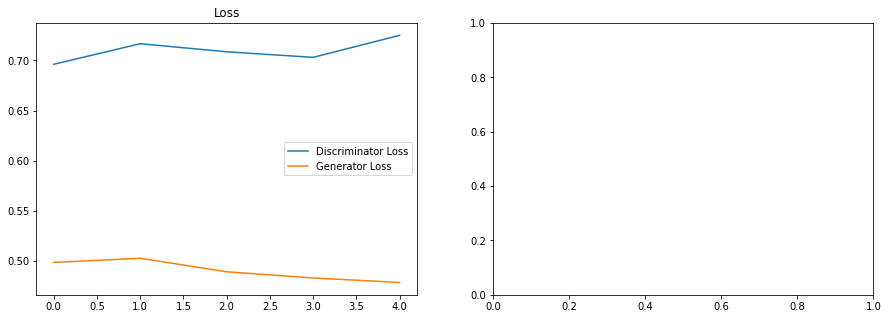

In [101]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history['d_loss'], label='Discriminator Loss')
plt.plot(history['g_loss'], label='Generator Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['d_acc'], label='Discriminator Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()
